<img src="img/dsci572_header.png" width="600">

# Lecture 6: Introduction to Convolutional Neural Networks



<br><br><br>

## Lecture Learning Objectives


- Describe the terms convolution, kernel/filter, pooling, and flattening

- Explain how convolutional neural networks (CNNs) work
- Calculate the number of parameters in a given CNN architecture
- Create a CNN in `PyTorch`
- Discuss the key differences between CNNs and fully connected NNs

<br><br><br>

## Imports


In [1]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
from utils.plotting import *

plt.rcParams.update({'axes.labelweight': 'bold', 'axes.grid': False})

<br><br><br>

## Motivation

- Have you used search in Google Photos?
- You can search for "my photos of cat" and it will retrieve photos from your libraries containing cats.
- This can be done using **image classification**.
- Image classification refers to predicting objects in images. It's treated as a supervised learning problem, where we define a set of target classes (objects to identify in images), and train a model to recognize them using labeled example photos.
- This is not an easy problem because of the variations in the location of the object, lighting, background, camera angle, camera focus etc.
 
![](img/cat_variation.png)

[Source](https://developers.google.com/machine-learning/practica/image-classification)

A significant advancement in image classification was the application of **convolutional neural networks** (ConvNets or CNNs) to this problem. 
- [ImageNet Classification with Deep Convolutional
Neural Networks](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
- Achieved a winning test error rate of 15.3%, compared to 26.2% achieved by the second-best entry in the ILSVRC-2012 competition. 

### A concrete example of detecting letters

Let's look into a toy example from Yan LeCun's (one of the major contributors in the development of CNNs) [slides](https://drive.google.com/file/d/18UFaOGNKKKO5TYnSxr2b8dryI-PgZQmC/view). 

Assume that 
- white $\rightarrow$ negative values with high magnitude
- black $\rightarrow$ positive values with high magnitude

![](img/letter-cnn.png)

### When should we use CNNs? 

- CNNs excel when handling input in the form of multidimensional arrays, particularly when nearby values within these arrays are similar or correlated.
- E.g., Image data, audio data, or text data
- A key function of CNNs is to detect patterns or motifs in an image, for example, regardless of their spatial location within the image.

### Big picture 
![](img/cnn_big_picture.png)

[Source](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks)

- Up until now we've been dealing with **fully connected neural networks** (FCNNs), meaning that every neuron in a given layer is connected to every neuron in the next layer. This has two key implications:

  1. It results in a LOT of parameters.

  2. The order of our features doesn't matter.
  
- Consider the image and FCNN below. For simplicity, assume that we have downsampled the image to 4 x 4 pixels:

<img src="img/cnn-1.png" width="700">

- Every input node is connected to every neuron in the next layer. Is that really necessary? Or better to say, is this the best thing to do?

- When you look at this image, how do you know that it's the image of a cat?

  - You notice the structure in the image (there's a face, ears, eyes, etc.)

  - You notice how different structures are positioned and related (the ears are at the top, two eyes in the middle, the face is rather round-shaped, etc.)

  - You probably use the shading (colour) to infer things about the image too

<br><br><br>

The point here is that there are some local relations between the input features (pixels), which determine the overall structure of objects in an image. This locality is lost when we feed each and every input feature to each and every neuron in a FCNN.

<br><br><br>

- So an idea is that we might be better off if we have each hidden neuron/node look only at a small area of the image, like this:

<img src="img/cnn-2.png" width="700">

- We have far fewer parameters now because we're acknowledging that pixels that are far apart are probably not all that related and so don't need to be connected.

- We're seeing that structure is important here, so then why should I need to flatten the image?

<br><br><br>

- Let's not flatten the image, but instead, make our hidden layer a 2D matrix:

<img src="img/cnn-3.png" width="800">

- As it stands, each group of 2 x 2 pixels has 4 unique weights associated with it (one for each pixel), which are being summed up into a single value in the hidden layer.

- But we don't need the weights to be different for each group, we're looking for **structure**, we don't care if the face is in the top left or the bottom right, we're just looking for a face.

> **If a transformation is useful to extract features from one part of an image, there's no reason that it shouldn't be useful for other parts of that image.**

<br><br><br>

- Let's summarize the weights into a weight "filter"

<img src="img/cnn-4.png" width="800">

<br><br><br>

- Let's see how the filter works

- We'll display some arbitrary values for our pixels
- The filter "convolves" over each group of pixels, multiplies corresponding elements and sums them up to give the values in the output nodes:

<img src="img/cnn-5.gif" width="800">

<br><br><br>

- As we'll see, we can add as many of these "filters" as we like to make more complex models that can identify more useful things:

<img src="img/cnn-6.png" width="800">

<br><br><br>

- We just made a **convolutional neural network** (CNN)

- Instead of fully-connected hidden nodes, we have 2D filters that we "convolve" over our input data

- This has two key advantages:

    1. We have less parameters than a fully connected network.
    
    2. We preserve the useful structure of our data.

<br><br><br>

## Convolutions and Filters

- Convolution really just means "to pass over the data"

- What are we "passing" over the data? Our filters, which are also called **kernels**

- Here's another GIF (source: adopted from [theano-pymc.readthedocs.io](https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html).) like the one we saw earlier:

![](img/conv-1.gif)

<br><br><br>

- So how does this help us extract structure from the data?
- Let's see some examples:

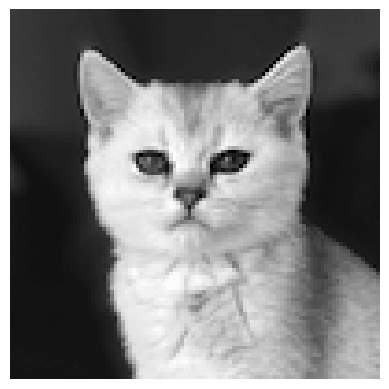

In [2]:
image = torch.from_numpy(plt.imread("img/cat.png"))[:, :, 0]
plt.imshow(image, cmap='gray')
plt.axis('off');

- We can blur this image by applying a filter with the following weights:

$$\begin{bmatrix} 0.0625 & 0.125 & 0.0625 \\ 0.125 & 0.25 & 0.125 \\ 0.0625 & 0.125 & 0.0625 \end{bmatrix}$$

In [3]:
kernel = torch.tensor([[[[ 0.0625,  0.1250,  0.0625],
                         [ 0.1250,  0.2500,  0.1250],
                         [ 0.0625,  0.1250,  0.0625]]]])

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


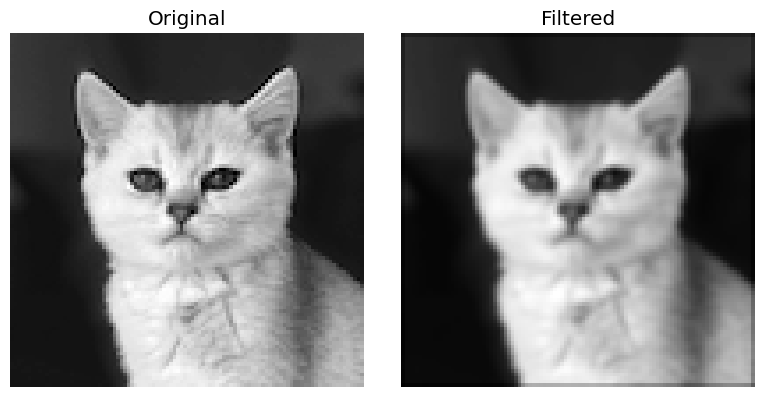

In [4]:
plot_conv(image, kernel)

<br><br><br>

- How about this one:

$$\begin{bmatrix} -2 & -1 & 0 \\ -1 & 1 & 1 \\ 0 & 1 & 2 \end{bmatrix}$$

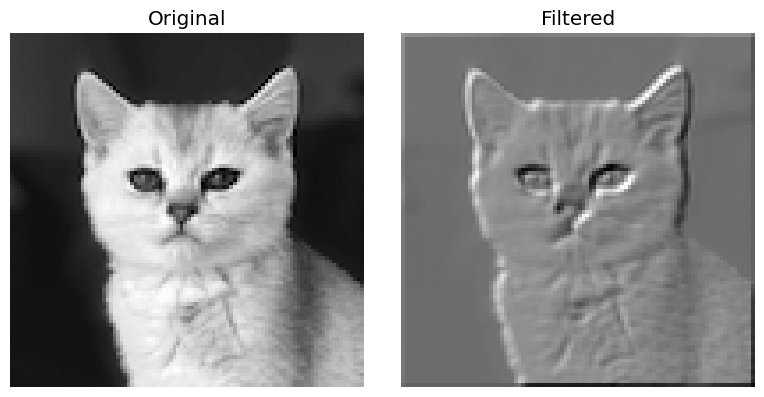

In [5]:
kernel = torch.tensor([[[[ -2,  -1,  0],
                         [ -1,   1,  1],
                         [  0,   1,  2]]]])
plot_conv(image, kernel)

<br><br><br>

- One more:

$$\begin{bmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{bmatrix}$$

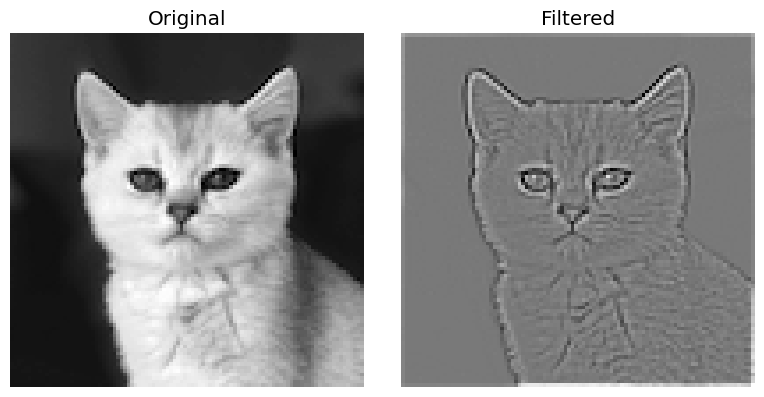

In [6]:
kernel = torch.tensor([[[[  -1,  -1,   -1],
                         [  -1,   8,   -1],
                         [  -1,  -1,   -1]]]])
plot_conv(image, kernel)

- [Here's a great website](https://setosa.io/ev/image-kernels/) where you can play around with other filters.

- We usually use **odd numbers for filters** so that they are applied symmetrically around our input data

- Did you notice in the GIF earlier that the output from applying our kernel was smaller than the input? Take a look again (source: adopted from [theano-pymc.readthedocs.io](https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html).):

![](img/conv-1.gif)

- Be default, our kernels are only applied where the filter fully fits on top of the input

- But we can control this behaviour and the size of our output with:

    - `padding`: "pads" the outside of the input with 0's to allow the kernel to reach the boundary pixels
    
    - `strides`: controls how far the kernel "steps" over pixels.

<br><br><br>

Below is an example with:
- `padding=1`: we have `1` layer of 0's around our border

- `strides=(2, 2)`: our kernel moves 2 data points to the right for each row, then moves 2 data points down to the next row

![](img/conv-2.gif)

(source: adopted from [theano-pymc.readthedocs.io](https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html))

## ❓❓ Questions for you

### Exercise 6.1

**iClicker cloud join link: https://join.iclicker.com/SDMQ**


![](img/conv-exercise.png)

What is the shape of the output feature map?

- (A) 4 by 4
- (B) 3 by 3
- (C) 2 by 2

[source](https://developers.google.com/machine-learning/practica/image-classification/check-your-understanding)

<br><br><br>

## Cooking up a CNN


### Ingredient 1: Convolutional Layers

- I showed some example kernels above

- In CNNs the actual values in **the kernel values are the weights your network will learn during training**: your network will learn what structures are important for prediction

- In PyTorch, convolutional layers are defined as `torch.nn.Conv2d`, there are 5 important arguments we need to know:

    1. `in_channels`: how many features are we passing in. Our features are our colour channels: in greyscale, we have 1 feature, in colour, we have 3 channels.
    
    2. `out_channels`: how many kernels do we want to use. Analogous to the number of hidden nodes in a hidden layer of a fully connected network.
    3. `kernel_size`: the size of the kernel. Above we were using 3x3. Common sizes are 3x3, 5x5, 7x7.
    4. `stride`: the "step-size" of the kernel.
    5. `padding`: the number of pixels we should pad to the outside of the image so we can get edge pixels.

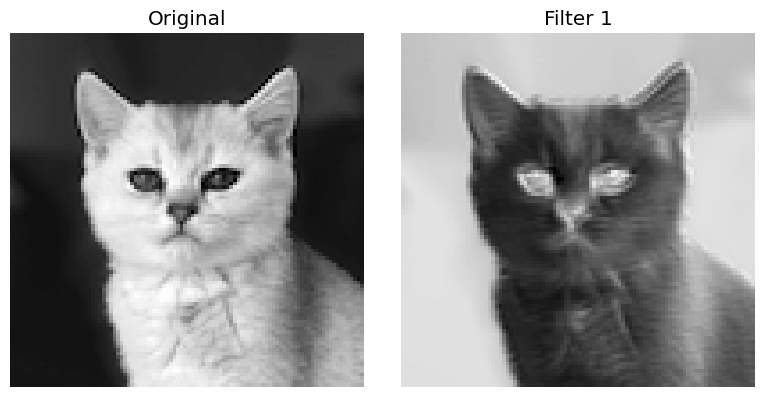

In [7]:
conv_layer = torch.nn.Conv2d(1, 1, kernel_size=(3, 3))
plot_convs(image, conv_layer)

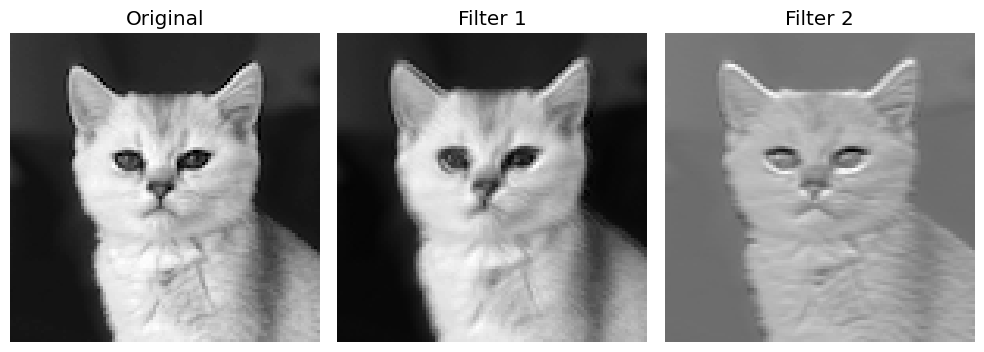

In [8]:
conv_layer = torch.nn.Conv2d(1, 2, kernel_size=(3, 3))
plot_convs(image, conv_layer)

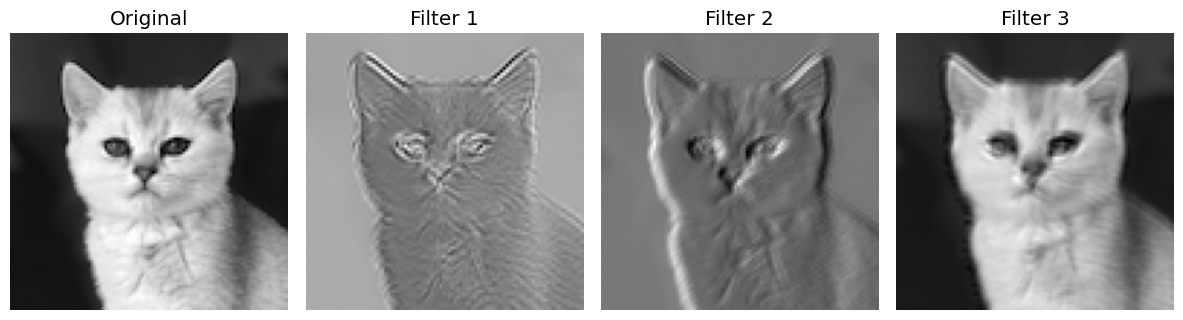

In [9]:
conv_layer = torch.nn.Conv2d(1, 3, kernel_size=(5, 5))
plot_convs(image, conv_layer)

- If we use a kernel with no padding, our output image will be smaller as we noted earlier

- Let's demonstrate that by using a larger kernel now:

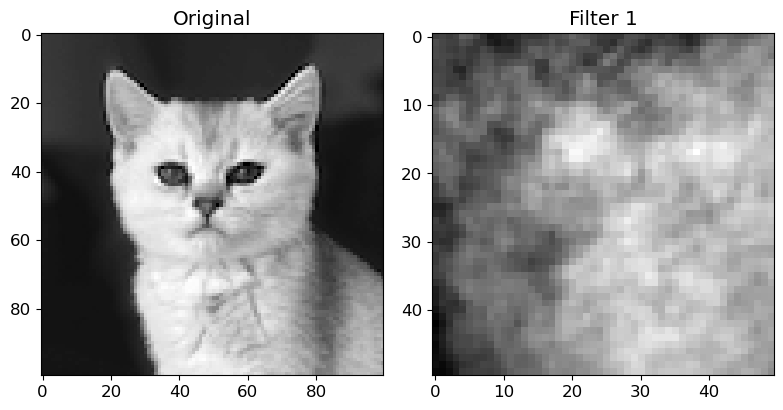

In [10]:
conv_layer = torch.nn.Conv2d(1, 1, kernel_size=(51, 51))
plot_convs(image, conv_layer, axis=True)

<br><br><br>

- As we saw, we can add `padding` to the outside of the image to avoid this:

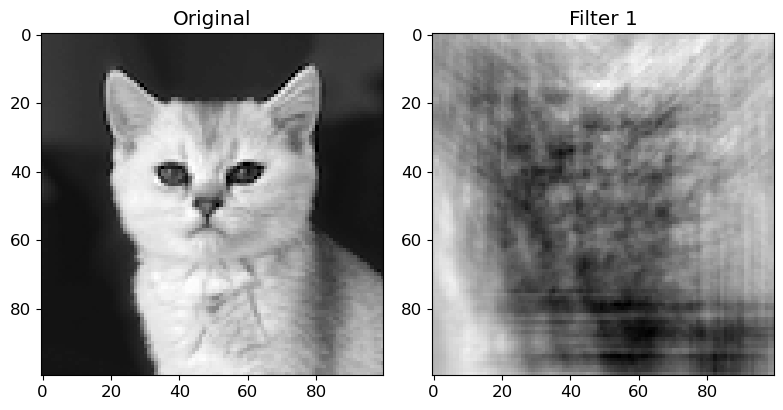

In [11]:
conv_layer = torch.nn.Conv2d(1, 1, kernel_size=(51, 51), padding=25)
plot_convs(image, conv_layer, axis=True)

> Setting `padding = kernel_size // 2` will always generate an output of the same shape as the input.

<br><br><br>

- Finally, we also saw before how `strides` influence the size of the output:

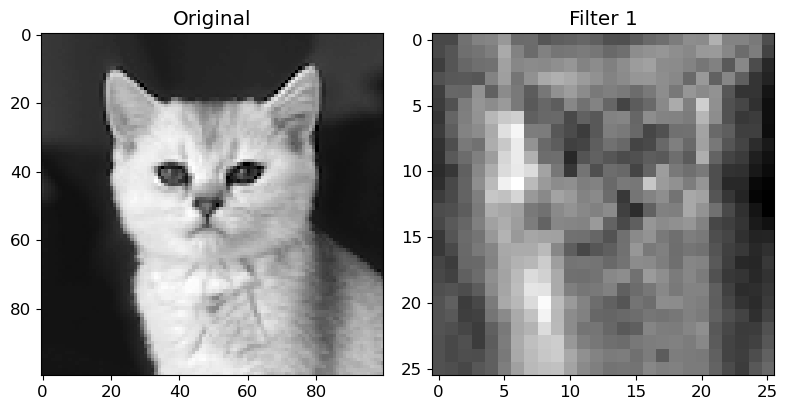

In [12]:
conv_layer = torch.nn.Conv2d(1, 1, kernel_size=(25, 25), stride=3)
plot_convs(image, conv_layer, axis=True)

<br><br><br>

- With CNNs, we are no longer flattening our data, so what are our "features"?

- Our features are called **channels** in CNN lingo: they are like the colour channels in an image:

    - A grey-scale image has 1 input feature/channel
    
    - A coloured image has 3 input features/channel

<img src="img/channels-1.png" width="600">

<br><br><br>

<img src="img/channels-2.png" width="600">

- What's important with CNNs is that the **size of our input data does not impact how many parameters we have in our convolutional layers**. In other words, the structure of the neural network is decoupled from the number of input dimensions

- For example, your kernels don't care how big your image is (i.e., 28 x 28 or 256 x 256), all that matters for the structure of the CNN is:

    1. How many features ("channels") you have: `in_channels`

    2. How many filters you use in each layer: `out_channels`

    3. How big the filters are: `kernel_size`

<br><br><br>

Let's see some diagrams:

<img src="img/cnn-7.png" width="700">

<br><br><br>

<br><br><br>

- For coloured images (3 channels):

<img src="img/cnn-8.png" width="700">

<br><br><br>

<br><br><br>

#### Dimensions of image and kernel tensors in PyTorch

**Images**: Regardless of whether we're dealing with input images or a transformed images (the output of a convolution layer), PyTorch stores them in 4-dimensional tensors with the following dimensions:

`(batch_size, n_channels, image_height, image_width)`

<br><br>

**Kernels**: kernels of each convolutional layer are stored as 4-dimensional tensors with these dimensions:

`(n_kernels, n_channels, kernel_height, kernel_width)`
  
> These particular shapes and dimensions are used in order to carry out the matrix operations in the CNN in the most space- and time-efficient way possible.

<br><br><br>

Let's have a look at an example:

In [13]:
image = torch.from_numpy(plt.imread("img/cat.png"))
image.shape

torch.Size([100, 100, 4])

That's the shape of the image when imported into Numpy and then into PyTorch. The first 3 channels are RGB channels, and sometimes we may also see a 4th channel for opacity of the image (in case of PNG images).

Although there are 3 colour channels, I have already converted this image to grey-scale, so all channels contain the same data (just light intensity).

<br><br><br>

Now let's take just one of the channels:

In [14]:
image = image[:, :, 0]
image.shape

torch.Size([100, 100])

<br><br><br>

OK, let's define a convolution layer, and pass our image to it:

In [15]:
conv_layer = torch.nn.Conv2d(1, 1, kernel_size=(5, 5))

Now if I run the following cell to pass the image to the conv layer, **it will throw an error**, because the image does not come in the shape that PyTorch expects it for the conv layer:

In [16]:
# conv_layer(image)

So I have to reshape the image into `(n_batches, n_channels, image_height, image_width)` first. Since I have just 1 batch of size 1, and 1 channel, I just need to add two extra dimensions:

In [17]:
image = image[None, None, :]
image.shape

torch.Size([1, 1, 100, 100])

In [18]:
conv_out = conv_layer(image)
conv_out.shape

torch.Size([1, 1, 96, 96])

It would have also been fine to pass a 3D tensor with dimensions of `(n_channels, image_height, image_width)`. In that case, PyTorch assumes **unbatched** input:

In [19]:
image = torch.from_numpy(plt.imread("img/cat.png"))[:, :, 0]
image.shape

torch.Size([100, 100])

In [20]:
conv_out = conv_layer(image[None, :])
conv_out.shape

torch.Size([1, 96, 96])

<br><br><br>

If we want to visualize our transformed image, there are two things we need to do first:

- Matplotlib works with Numpy array and doesn't understand PyTorch tensors, so it tries to convert the output of the conv layer to a Numpy array. But for Matplotlib to be able to do that, we first need to **detach** the tensor from PyTorch's computational graph (basically to tell PyTorch that we don't want the computations on this tensor to be tracked), so we have to do `.detach()` on the tensor.

- Matplotlib also only understands 2-dimensional arrays for `plt.imshow()`, so we have to remove the extra dimensions from the output of the conv layer. One way to do it is to use `.squeeze()`, which removes all dimensions of size 1.

In [21]:
conv_out = conv_layer(image[None, None, :])
conv_out.shape

torch.Size([1, 1, 96, 96])

In [22]:
conv_out.squeeze().shape

torch.Size([96, 96])

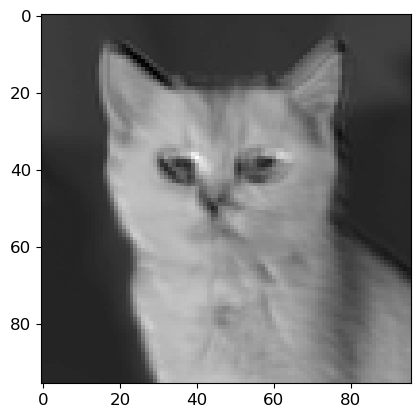

In [23]:
plt.imshow(conv_layer(image[None, None, :]).detach().squeeze(), cmap='gray')

<br><br><br>

### Ingredient 2: Flattening

- With our convolutional layers, we're basically just passing images through the network

- But we're going to eventually want to do some regression or classification

- That means that by the end of our network, we are going to need to `torch.nn.Flatten()` our images:

<img src="img/cnn-9.png" width="800">

<br><br><br>

- Let's make that simple CNN above in PyTorch:

In [24]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Linear(20000, 1)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [25]:
model = CNN()
summary(model, (1, 100, 100));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 3, 100, 100]         30
|    └─ReLU: 2-2                         [-1, 3, 100, 100]         --
|    └─Conv2d: 2-3                       [-1, 2, 100, 100]         56
|    └─ReLU: 2-4                         [-1, 2, 100, 100]         --
|    └─Flatten: 2-5                      [-1, 20000]               --
|    └─Linear: 2-6                       [-1, 1]                   20,001
Total params: 20,087
Trainable params: 20,087
Non-trainable params: 0
Total mult-adds (M): 0.85
Input size (MB): 0.04
Forward/backward pass size (MB): 0.38
Params size (MB): 0.08
Estimated Total Size (MB): 0.50


- 20,000 parameters in that last layer, that's a lot of parameters

- Is there a way we can reduce this?

<br><br><br>

### Ingredient 3: Pooling

- In general, we use **pooling layers** for reducing the dimensionality of the transformed images, such that when we eventually flatten the transformed images (using `torch.nn.Flatten()`), we end up with smaller number of parameters for our CNN.

- It's common practice to do **max pooling** or **average pooling**

<br><br><br>

- Max pooling seems to work quite well. One explanation for that could be that it derives the sharpest features of a transformed image.

- Here's an example of **max pooling**:

![](img/pool.gif)

(source: adopted from [www.oreilly.com](https://www.oreilly.com/radar/visualizing-convolutional-neural-networks/))

<br><br><br>

- We can implement pooling with `torch.nn.MaxPool2d()`

- Let's try it out and reduce the number of parameters:

In [26]:
class CNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            
            torch.nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((2, 2)),
            
            torch.nn.Flatten(),
            torch.nn.Linear(1250, 1)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [27]:
model = CNN()
summary(model, (1, 100, 100));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 3, 100, 100]         30
|    └─ReLU: 2-2                         [-1, 3, 100, 100]         --
|    └─MaxPool2d: 2-3                    [-1, 3, 50, 50]           --
|    └─Conv2d: 2-4                       [-1, 2, 50, 50]           56
|    └─ReLU: 2-5                         [-1, 2, 50, 50]           --
|    └─MaxPool2d: 2-6                    [-1, 2, 25, 25]           --
|    └─Flatten: 2-7                      [-1, 1250]                --
|    └─Linear: 2-8                       [-1, 1]                   1,251
Total params: 1,337
Trainable params: 1,337
Non-trainable params: 0
Total mult-adds (M): 0.41
Input size (MB): 0.04
Forward/backward pass size (MB): 0.27
Params size (MB): 0.01
Estimated Total Size (MB): 0.31


- We reduced that last layer to 1,251 parameters (~16 times smaller than the original number)

<br><br><br>

## The CNN Recipe


- Here's a CNN diagram of a famous architecture called [AlexNet](https://en.wikipedia.org/wiki/AlexNet) after  Alex Krizhevsky ([Geoffrey Hinton](https://en.wikipedia.org/wiki/Geoffrey_Hinton)'s PhD student). We'll talk more about other famous architectures next lecture:

<img src="img/alexnet.png" width="700">

- You actually know what all of the above means by now

- But, deep learning and CNN architecture still has a strong empirical (though science based) component to it, but people are working hard on making things more systematic (interpretable ML, physics-based ML, etc.)

- Here is a general recipe (based on experience, common practice, and popular pre-made architectures)

- Typical ingredients (in order):

    - Convolution layer(s): `torch.nn.Conv2d`

    - Activation function: `torch.nn.ReLU`, `torch.nn.LeakyReLU`, etc.
    - (optional) Batch normalization: `torch.nn.BatchNorm2d` (more on that next lecture)
    - (optional) Pooling: `torch.nn.MaxPool2d`
    - (optional) Drop out: `torch.nn.Dropout`
    - Flatten: `torch.nn.Flatten`

- I'll be getting you to implement a CNN for our Bitmoji dataset from last lecture in lab this week so you can get some practice in there.

<br><br><br>

## CNN vs FCNN


- As an example of the parameter savings introduced when using CNNs with structured data, let's compare the Bitmoji classifier from last lecture, with an equivalent CNN version

- We'll replace all linear layers with convolutional layers with 3 kernels of size (3, 3) and will assume an image size of 128 x 128:

In [28]:
def linear_block(input_size, output_size):
    return torch.nn.Sequential(
        torch.nn.Linear(input_size, output_size),
        torch.nn.ReLU()
    )


def conv_block(input_channels, output_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(input_channels, output_channels, (3, 3), padding=1),
        torch.nn.ReLU()
    )


class FCNN(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.main = torch.nn.Sequential(
            linear_block(input_size, 256),
            linear_block(256, 128),
            linear_block(128, 64),
            linear_block(64, 32),
            torch.nn.Linear(32, 16),
            torch.nn.Linear(16, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out


class CNN(torch.nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.main = torch.nn.Sequential(
            conv_block(input_channels, 3),
            conv_block(3, 3),
            conv_block(3, 3),
            conv_block(3, 3),
            conv_block(3, 3),
            torch.nn.Flatten(),
            torch.nn.Linear(49152, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [29]:
model = FCNN(input_size=128 * 128)
summary(model, (128 * 128,));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 256]                 --
|    |    └─Linear: 3-1                  [-1, 256]                 4,194,560
|    |    └─ReLU: 3-2                    [-1, 256]                 --
|    └─Sequential: 2-2                   [-1, 128]                 --
|    |    └─Linear: 3-3                  [-1, 128]                 32,896
|    |    └─ReLU: 3-4                    [-1, 128]                 --
|    └─Sequential: 2-3                   [-1, 64]                  --
|    |    └─Linear: 3-5                  [-1, 64]                  8,256
|    |    └─ReLU: 3-6                    [-1, 64]                  --
|    └─Sequential: 2-4                   [-1, 32]                  --
|    |    └─Linear: 3-7                  [-1, 32]                  2,080
|    |    └─ReLU: 3-8                    [-1, 32]                  -

In [30]:
model = CNN(input_channels=1)
summary(model, (1, 128, 128));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 3, 128, 128]         --
|    |    └─Conv2d: 3-1                  [-1, 3, 128, 128]         30
|    |    └─ReLU: 3-2                    [-1, 3, 128, 128]         --
|    └─Sequential: 2-2                   [-1, 3, 128, 128]         --
|    |    └─Conv2d: 3-3                  [-1, 3, 128, 128]         84
|    |    └─ReLU: 3-4                    [-1, 3, 128, 128]         --
|    └─Sequential: 2-3                   [-1, 3, 128, 128]         --
|    |    └─Conv2d: 3-5                  [-1, 3, 128, 128]         84
|    |    └─ReLU: 3-6                    [-1, 3, 128, 128]         --
|    └─Sequential: 2-4                   [-1, 3, 128, 128]         --
|    |    └─Conv2d: 3-7                  [-1, 3, 128, 128]         84
|    |    └─ReLU: 3-8                    [-1, 3, 128, 128]         --
|    └─Sequenti

- No pooling and our CNN has 49,519 parameters vs 4,238,337

- This is a somewhat arbitrary comparison, but it demonstrates the point
- We'll explore how accurate our CNN is in the lab

<br><br><br>

## ❓❓ Questions for you

### Exercise 6.2

**iClicker cloud join link: https://join.iclicker.com/SDMQ**

**Select all of the following statements which are TRUE.**

- (A) The *input* to a `torch.nn.Conv2D` layer is a 2D tensor.
- (B) The *output* of a `torch.nn.Conv2D` layer is a 2D tensor.
- (C) The parameters of a torch.nn.Conv2D layer form a 4D array.
- (D) Adding more fully connected layers (after flattening) always increases the number of parameters of a convnet.
- (E) A CNN with more convolutional layers always has more parameters than a CNN with fewer convolutional layers.

```{admonition} V's Solutions!
:class: tip, dropdown
1. False. it’s a 4D tensor with dimensions (batch_size, n_channels, image_height, image_width)
2. False. it’s a 4D tensor with dimensions (batch_size, n_channels, image_height, image_width)
3. True. Each kernel (or filter) is a 4D tensor with dimensions (n_kernels, n_channels, kernel_height, kernel_width)
4. True. More fully connected layers means more weights. 
5. False. The size of kernels, number of output channels of each conv layer, and the output of the last layer before flattening can make a CNN with fewer convolutional layers have more parameters than a CNN with more convolutional layers.

```

<br><br><br>

## Lecture Highlights


1. CNNs help us utilize the structure in our data to make predictions. They also typically have less parameters than fully connected networks.

2. CNNs use filters/kernels which "convolve" over localized areas of the data.
3. The core ingredients of CNNs are: convolutional layers, pooling layers, flattening layers